<a href="https://colab.research.google.com/github/LordLean/California-House-Prices/blob/main/house_prices_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [ ]:
!wget https://raw.githubusercontent.com/LordLean/California-House-Prices/main/housing.csv

--2021-11-25 15:16:41--  https://raw.githubusercontent.com/LordLean/California-House-Prices/main/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1159215 (1.1M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1.11M  --.-KB/s    in 0.04s   

2021-11-25 15:16:41 (31.4 MB/s) - ‘housing.csv’ saved [1159215/1159215]



# Model

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import time 

import torch
import torch.nn as nn

import pickle

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import mean_squared_error

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class Regressor(nn.Module):

    
    def __init__(self, x, nb_epoch = 1000):
        # You can add any input parameters you need
        # Remember to set them with a 
        # default value for LabTS tests
        """ 
        Initialise the model.
          
        Arguments:
            - x {pd.DataFrame} -- Raw input data of shape 
                (batch_size, input_size), used to compute the size 
                of the network.
            - nb_epoch {int} -- number of epoch to train the network.

        """

        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # Super class constructor.
        super().__init__()
        # Replace this code with your own
        X, _ = self._preprocessor(x, training = True)
        self.input_size = X.shape[1]
        self.output_size = 1
        self.nb_epoch = nb_epoch


        self._sequential = nn.Sequential(
            nn.Linear(self.input_size, 50),
            nn.ReLU(),
            nn.Linear(50, 30),
            nn.ReLU(),
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, self.output_size)
        )


        # Initialization of linear layers.
        # self._sequential.apply(self._weight_initialization)

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################



    
    def forward(self, x):
      return self._sequential(x)
    

    
    def _preprocessor(self, x, y = None, training = False):
        """ 
        Preprocess input of the network.
          
        Arguments:
            - x {pd.DataFrame} -- Raw input array of shape 
                (batch_size, input_size).
            - y {pd.DataFrame} -- Raw target array of shape (batch_size, 1).
            - training {boolean} -- Boolean indicating if we are training or 
                testing the model.

        Returns:
            - {torch.tensor} or {numpy.ndarray} -- Preprocessed input array of
              size (batch_size, input_size).
            - {torch.tensor} or {numpy.ndarray} -- Preprocessed target array of
              size (batch_size, 1).

        """

        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # NaNs.
        numeric_columns = x.select_dtypes(include=[np.number]).columns
        for col in numeric_columns:
          x[col].fillna((x[col].mean()), inplace=True)

        # Categorical one-hot encoding.
        # x = self._one_hot(x, training)
        if "ocean_proximity" in x.columns:
          x.drop("ocean_proximity",axis=1,inplace=True)

        # Scaler
        if training:
          # Create scaler objects.
          self.x_scaler = MinMaxScaler()
          # Scale and store transformation.
          x = self.x_scaler.fit_transform(x)
          if y is not None:
            self.y_scaler = MinMaxScaler()
            y = self.y_scaler.fit_transform(y.to_numpy().reshape(-1,1))
        else:
          # Scale only.
          x = self.x_scaler.transform(x)
          # For scoring function.
          if y is not None:
            y = self.y_scaler.transform(y.to_numpy().reshape(-1,1))

        # Tensor conversion.
        x = torch.tensor(x, dtype=torch.float)
        if y is not None:
          y = torch.tensor(y, dtype=torch.float)

        # Return preprocessed x and y, return None for y if it was None
        return x.to(device), (y.to(device) if y is not None else None)

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################


    
    def _one_hot(self, X, training):
      """ 
        One-hot encode categorical data within passed dataframe.
          
        Arguments:
            - X {pd.DataFrame} -- Raw input array of shape 
                (batch_size, input_size).

        Returns:
            - X {pd.DataFrame} -- Input array of shape 
                (batch_size, input_size + num_of_new_categories).
      """
      if training:
        # Create encoder instance and fit-transform to ocean proximity series.
        self.enc = OneHotEncoder()
        X_one_hot = self.enc.fit_transform(X.ocean_proximity.values.reshape(-1,1)).toarray()
        new_X = X.drop("ocean_proximity", axis=1)
      else:
        X_one_hot = self.enc.transform(X.ocean_proximity.values.reshape(-1,1)).toarray()
        new_X = X.drop("ocean_proximity", axis=1)
      # Create one-hot encoded dataframe for ocean proximity.
      cat_names = [name for name in self.enc.categories_[0]]
      df_one_hot = pd.DataFrame(X_one_hot, columns = cat_names)
      new_X = pd.concat([new_X, df_one_hot], axis=1)
      return new_X

        
    
    def fit(self, x, y,
            lr=1e-3, opt_func=torch.optim.Adam, batch_size=512,
            regularizer=None, lambda_decay=1e-5,
            callbacks = {},
            validation_set=None):
        """
        Regressor training function

        Arguments:
            - x {pd.DataFrame} -- Raw input array of shape 
                (batch_size, input_size).
            - y {pd.DataFrame} -- Raw output array of shape (batch_size, 1).
            - lr {float} -- Learning rate.
            - opt_func {torch.optim} -- Optimizer function.
            - batch_size {int} -- Used for mini-batch gradient descent. =1 for SGD, X.shape[0] for batch.
            - regularizer {str} -- L1 or L2, not case-sensitive.
            - lambda_decay {float} -- Coeff: lambda for regularization computations.
            - callbacks {dict} -- Store variables corresponding to early-stopping and verbose training process.
            - validation_set {list} [X_val, y_val] -- Validation set, used for calculating validation loss.
        Returns:
            self {Regressor} -- Trained model.

        """

        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # global loss

        self.hyper_params = {
            "lr":lr, "opt_func":opt_func, "batch_size":batch_size,
            "regularizer":regularizer, "lambda_decay":lambda_decay,
        }

        # Preprocess data.
        X, y = self._preprocessor(x, y = y, training = True) # Do not forget
        if validation_set:
          X_val, y_val = validation_set
          X_val, y_val = self._preprocessor(X_val, y=y_val, training=False)

        # Callback variables
        verbose = callbacks.get("verbose", False)
        monitor = callbacks.get("monitor", "val_loss")
        patience = callbacks.get("patience", 9)
        early_stopping = callbacks.get("early_stopping", True)
        # Early stopping variables.
        es_count = 0
        loss_to_beat = None # Var to store best loss within patience range.

        # batch, mini-batch, etc.
        dataset = torch.utils.data.TensorDataset(X,y)
        data_loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=batch_size if batch_size is not None else X.shape[0],
            shuffle=True, drop_last=True
        )

        # Loss function.
        criterion = nn.MSELoss()
        # Optimizer.
        optimizer = opt_func(self.parameters(), lr)
        # History to store: epochs, loss, (val_loss)
        self.history = []

        for epoch in range(self.nb_epoch):
          # Gradient computations.
          for i , (inputs, targets) in enumerate(data_loader):
            # Reset gradients
            optimizer.zero_grad()
            # Forward
            y_pred = self.forward(inputs)
            # Loss
            loss = criterion(y_pred, targets)
            # End training if:
            if torch.isnan(loss) or torch.isinf(loss):
              if verbose:
                print("Training ended: loss is Nan or Inf.")
                print("Epoch: {}, Loss: {}".format(epoch,loss))
              break
            # Perform weight regularization (if specified, else loss is unchanged).
            loss = self._weight_regularization(loss, regularizer, lambda_decay)
            # Backward
            loss.backward()
            # Update Parameters
            optimizer.step()

          # Data collected per epoch.
          epoch_data = (epoch, loss.item())
          # Predictions on validation set.
          if validation_set:
            # Prevent gradient mutations.
            with torch.no_grad():
              y_pred_val = self.forward(X_val)
              val_loss = criterion(y_pred_val, y_val)
              # add val_loss to epoch_data tuple.
              epoch_data += (val_loss.item(),)

          if early_stopping:
            # Early stopping function.
            es_count, loss_to_beat, curr_loss = self._early_stopping(
                monitor, es_count, loss_to_beat, epoch_data,
                is_val=True if validation_set else False)
            # Patience check
            if es_count == patience:
              if verbose:
                print("Training ended, early stopping at:")
                print("Epoch: {}, {}: {}\nloss-to-beat: {}".format(epoch, monitor, curr_loss, loss_to_beat))
              self.history.append(epoch_data)
              break # If early-stopping criteria met.
            
          # Store epoch, loss in history list.
          self.history.append(epoch_data)
          # # Print training process.
          if verbose:
            self._verbose()
        
        return self


        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################


    def _early_stopping(self, monitor, es_count, loss_to_beat, epoch_data, is_val):
      """
      Maintains early-stopping-counter and the loss-to-beat which needs to be improved upon.

      Arguments:
          monitor {str} -- String object pointing model to monitor either loss or val_loss.
          es_count {int} -- Counter to record how many epochs since loss-to-beat.
          loss_to_beat {float} -- The lowest loss within a patience range. 
          epoch_data {tuple} -- Tuple holding epoch, loss, (val_loss) - recorded in history.
          is_val {bool} -- Boolean corresponding to whether validation set is present within .fit().
          
      Returns:
          {np.darray} -- Predicted value for the given input (batch_size, 1).

      """
      # Early Stopping - val_loss or loss.
      i_loss = None
      if monitor == "val_loss" and is_val:
        # Counter to index epoch_data and previous 'history' record.
        i_loss = 2
        curr_loss = epoch_data[i_loss] # Validation Loss
      else:
        i_loss = 1
        curr_loss = epoch_data[i_loss] # Loss
      # Early stopping checks.
      if loss_to_beat is None:
        if self.history: # If list is not empty.
          if curr_loss > self.history[-1][i_loss]: # If new loss is greater than prev loss.
            loss_to_beat = self.history[-1][i_loss] # Set loss to beat to be prev loss.
            es_count += 1 # Increment doomsday counter
      elif loss_to_beat is not None:
        if curr_loss > loss_to_beat: # If new loss continues to underperform loss to beat.
          es_count += 1 # Increment doomsday counter
        else:
          loss_to_beat = None # Loss to beat was beaten, reset variable.
          es_count = 0 
      return es_count, loss_to_beat, curr_loss

            
    
    def predict(self, x):
        """
        Ouput the value corresponding to an input x.

        Arguments:
            x {pd.DataFrame} -- Raw input array of shape 
                (batch_size, input_size).

        Returns:
            {np.darray} -- Predicted value for the given input (batch_size, 1).

        """

        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        # Preprocess test data.
        X, _ = self._preprocessor(x, training = False) # Do not forget
        
        # Predict.
        y_pred = self.forward(X)
        # Detach Tensor.
        y_pred = y_pred.detach().cpu().numpy()
        # Inverse Scale.
        y_pred = self.y_scaler.inverse_transform(y_pred)
        return y_pred

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    
    def score(self, x, y):
        """
        Function to evaluate the model accuracy on a validation dataset.

        Arguments:
            - x {pd.DataFrame} -- Raw input array of shape 
                (batch_size, input_size).
            - y {pd.DataFrame} -- Raw ouput array of shape (batch_size, 1).

        Returns:
            {float} -- Quantification of the efficiency of the model.

        """

        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        y_pred = self.predict(x)

        rmse = mean_squared_error(y, y_pred, squared=False)

        return rmse

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################


    def _weight_initialization(self, module):
      '''
      Weight initialization. 
      https://pytorch.org/docs/stable/nn.init.html
      '''
      if isinstance(module, nn.Linear):
        torch.nn.init.kaiming_uniform_(module.weight, nonlinearity="relu")

    
    def _weight_regularization(self, loss, reg, decay):
      '''
      Perform weight regularization.
      '''
      # Weight Decay
      if reg is not None and isinstance(reg, str):
        reg = reg.lower()
        if reg not in ["l1", "l2"]:
          raise ValueError("This model only accepts L1 or L2 regularization")
        else:
          if reg == "l1":
            # Only apply regularization to weights (not biases).
            lx_norm = sum(p.abs().sum() for name, p in self.named_parameters() if "bias" not in name)
          if reg == "l2":
            lx_norm = sum(p.pow(2.0).sum() for name, p in self.named_parameters() if "bias" not in name)
          # Perform weight regularization.
          loss = loss + decay * lx_norm
      return loss

    
    
    def _verbose(self):
      '''
      Print training scores of model during fit function.
      '''
      epoch_data = self.history[-1]
      if epoch_data[0] % 10 == 0:
        if len(epoch_data) == 3:
          e, l, v_l = epoch_data
          print("Epoch: {:3}, Loss: {:18.18f}, Val-Loss: {:18.18f}".format(e, l, v_l))
        else:
          e, l = epoch_data
          print("Epoch: {:3}, Loss: {:18.18f}".format(e, l))


    def plot_performance(self):
      '''
      Plot training performance of model.
      '''
      try:
        sns.set_theme(style="darkgrid")
        # Loss list.
        l_list = [item[1] for item in self.history]
        # Validation Loss list.
        v_l_list = [item[2] for item in self.history] if len(self.history[0]) == 3 else []
        sns.lineplot(x=range(len(l_list)), y=l_list, label="Loss")
        if len(v_l_list): # If validation loss list is not empty.
          sns.lineplot(x=range(len(l_list)), y=v_l_list, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
      except NameError:
        print("Matplotlib.pyplot must be imported as 'plt'\n Seaborn must be imported as 'sns'")
    

    def get_model(self):
      print(self._sequential)
      return self._sequential

## Model Example

In [ ]:
# Reset.
df = pd.read_csv('housing.csv', index_col=None)

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [ ]:
callbacks = {
    "verbose" : True,
    "monitor" : "val_loss",
    "patience" : 8,
    "early_stopping" : True
}

In [ ]:
regressor = Regressor(X_train, nb_epoch=100).to(device)

In [ ]:
regressor.fit(X_train,y_train, callbacks=callbacks, validation_set=[X_val, y_val])

Epoch:   0, Loss: 0.103712387382984161, Val-Loss: 0.107765175402164459
Epoch:  10, Loss: 0.025479033589363098, Val-Loss: 0.020179713144898415
Epoch:  20, Loss: 0.022268872708082199, Val-Loss: 0.017977703362703323
Epoch:  30, Loss: 0.013221010565757751, Val-Loss: 0.016370706260204315
Epoch:  40, Loss: 0.013555144891142845, Val-Loss: 0.015420037321746349
Epoch:  50, Loss: 0.015573468059301376, Val-Loss: 0.015022816136479378
Epoch:  60, Loss: 0.014338520355522633, Val-Loss: 0.014994715340435505
Epoch:  70, Loss: 0.014799193479120731, Val-Loss: 0.014264337718486786
Epoch:  80, Loss: 0.012671851553022861, Val-Loss: 0.014657923020422459
Epoch:  90, Loss: 0.016340948641300201, Val-Loss: 0.013979993760585785


Regressor(
  (_sequential): Sequential(
    (0): Linear(in_features=8, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=20, bias=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [ ]:
rmse = regressor.score(X_test, y_test)
rmse

59141.10624415515

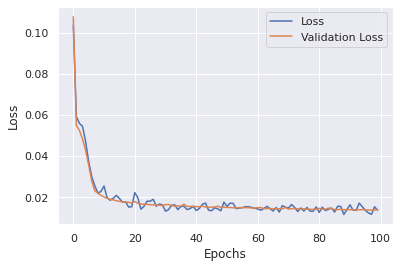

In [ ]:
regressor.plot_performance()

# Hyper-Parameter Tuning

## Exhaustive Grid-Search

In [ ]:
# Reset.
df = pd.read_csv('housing.csv', index_col=None)
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

columns=["optimizer", "learning_rate", "regularizer", "regularizer_lambda", "batch_size", "rmse", "epoch", "train_time", "model"]
df_hyper_param = pd.DataFrame(columns=columns)

In [ ]:
opt_list = [torch.optim.Adam, torch.optim.AdamW, torch.optim.SGD, torch.optim.RMSprop]
lr_list = [0.5e-2, 1e-3, 0.5e-3, 1e-4]
mini_batch_list = [32,64,128,256,512,1024,2048,None]
regularizer_list = [None, "l1", "l2"]
lambda_decay_list = [1e-3, 1e-4, 1e-5]

# download_indx = 0
row_indx = 0
for opt in opt_list:
  # Get optimizer name as str.
  opt_name = str(opt).split(".")[-1][:-2]
  print(opt_name)

  for lr in lr_list:
    print("   lr:{}".format(lr))

    for mini_batch in mini_batch_list:
      print("       mini_batch:{}".format(mini_batch))
      
      for reg in regularizer_list:
        print("           regularizer:{}".format(reg))

        for lambda_decay in lambda_decay_list:
          print("             lambda_decay:{}".format(lambda_decay if reg is not None else 0))
          
          # Split data.
          X_train, X_test, y_train, y_test = train_test_split(X,y)
          # Validation
          X_train, X_val, y_train, y_val = train_test_split(X_train,y_train)

          callbacks = {
              "verbose" : False,
              "monitor" : "val_loss",
              "patience" : 8
          }

          # if mini_batch is not None and mini_batch < 129:
          #   callbacks["patience"] = 5
              
          # Instance, fit, and score regressor model.
          regressor = Regressor(X_train, nb_epoch=300).to(device)

          # Time training process.
          start_time = time.time()
          regressor.fit(X_train,y_train, lr=lr, opt_func=opt, regularizer=reg, lambda_decay=lambda_decay, batch_size=mini_batch, callbacks=callbacks, validation_set=[X_val,y_val])
          train_time = time.time() - start_time

          rmse = regressor.score(X_test, y_test)

          # Create hyperparameter dataframe.
          df_hyper_param.loc[row_indx] = [
                                          opt_name,
                                          lr,
                                          reg if reg is not None else "l0",
                                          lambda_decay if reg is not None else np.NINF,
                                          mini_batch if mini_batch is not None else np.inf,
                                          rmse,
                                          regressor.history[-1][0], # epochs trained.
                                          train_time, # Time taken to train.
                                          regressor
          ]

          # Incremete row index.
          row_indx+=1
          
          # If no regularizer than skip all but one lambda_decay training values.
          if reg is None:
            break

    # download_indx += 1
    # save_dataframe(df_hyper_param, download_indx)

Adam
   lr:0.005
       mini_batch:32
           regularizer:None
             lambda_decay:0
           regularizer:l1
             lambda_decay:0.001
             lambda_decay:0.0001
             lambda_decay:1e-05
           regularizer:l2
             lambda_decay:0.001
             lambda_decay:0.0001
             lambda_decay:1e-05
       mini_batch:64
           regularizer:None
             lambda_decay:0
           regularizer:l1
             lambda_decay:0.001
             lambda_decay:0.0001
             lambda_decay:1e-05
           regularizer:l2
             lambda_decay:0.001
             lambda_decay:0.0001
             lambda_decay:1e-05
       mini_batch:128
           regularizer:None
             lambda_decay:0
           regularizer:l1
             lambda_decay:0.001
             lambda_decay:0.0001
             lambda_decay:1e-05
           regularizer:l2
             lambda_decay:0.001
             lambda_decay:0.0001
             lambda_decay:1e-05
       mini_b

In [ ]:
# Cut all rows with rmse above cut
cut = 100000
cut_rows = len(df_hyper_param)
df_hyper_param = df_hyper_param.query("rmse < {}".format(cut))
print("Cut {} records.".format(cut_rows - len(df_hyper_param)))

Cut 239 records.


## Parallel Coordinates

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

In [ ]:
##########################################################################
# Uncomment to create randomly generated df for parallel coordinates plot.
##########################################################################

# columns=["optimizer", "learning_rate", "regularizer", "regularizer_lambda", "batch_size", "rmse", "model", "train_time"]
# df_hyper_param = pd.DataFrame(columns=columns)
# for i in range(100):
#   df_hyper_param.loc[i] = [np.random.choice(["Adam","SGD", "RMSProp"]),
#                     np.random.choice([0.5e-2, 1e-3, 0.5e-3, 1e-4, 0.5e-4]),
#                     np.random.choice(["l0", "l1", "l2"]),
#                     np.random.choice([0.5e-2, 1e-3, 0.5e-3, 1e-4, 0.5e-4]),
#                     np.random.choice([32,64,128,256,512,1024,2048, np.inf]),
#                     np.random.randint(10000),
#                     regressor,
#                     np.random.randint(10)]

In [ ]:
def enc_column(col_name, df):
  '''
  Function to convert dataframe column from datatype to label encoded integers.
  Useful for plotting parallel coordinates.
  '''

  # Get sorted list of column names, ABC or 123.
  col_names = list(df[col_name].unique())
  col_names.sort()

  # Dictionary to transform actual value to numeric label.
  encoder = {name : i for i, name in enumerate(col_names)}
  
  # Function to return numeric label from actual value.
  def col_enc(col_num):
    return encoder[col_num]

  # Mutate df dataframe in-place.
  df[col_name] = df[col_name].apply(col_enc)

  return col_names, df

In [ ]:
# Label Encoding.
opt_names, df_hyper_param = enc_column("optimizer", df_hyper_param)

lr_names, df_hyper_param = enc_column("learning_rate", df_hyper_param)

regularizer_names, df_hyper_param = enc_column("regularizer", df_hyper_param)
regularizer_names[0] = "None" # Indicates no regularization.

regularizer_lambda_names, df_hyper_param = enc_column("regularizer_lambda", df_hyper_param)
regularizer_lambda_names[0] = "None" # Indicates no regularization so no decay.

batch_names, df_hyper_param = enc_column("batch_size", df_hyper_param)
batch_names[-1] = "None" # Indicates no mini-batch.

In [ ]:
fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = df_hyper_param['rmse'],
                   colorscale = [[0,'purple'],[0.5,'lightseagreen'],[1,'gold']]),
                  #  colorscale = "Electric"),
        dimensions = list([

            dict(range = [df_hyper_param['optimizer'].min(), df_hyper_param['optimizer'].max()],
                tickvals = list(range(len(opt_names))),
                label = 'Optimizer', values = df_hyper_param['optimizer'],
                ticktext = opt_names),
            
            dict(range = [df_hyper_param['learning_rate'].min(), df_hyper_param['learning_rate'].max()],
                tickvals = list(range(len(lr_names))),
                label = 'Learning Rate', values = df_hyper_param['learning_rate'],
                ticktext = lr_names),
            
            dict(range = [df_hyper_param['regularizer'].min(), df_hyper_param['regularizer'].max()],
                tickvals = list(range(len(regularizer_names))),
                label = 'Regularizer', values = df_hyper_param['regularizer'],
                ticktext = regularizer_names),
            
            dict(range = [df_hyper_param['regularizer_lambda'].min(), df_hyper_param['regularizer_lambda'].max()],
                tickvals = list(range(len(regularizer_lambda_names))),
                label = 'Regularizer Lambda', values = df_hyper_param['regularizer_lambda'],
                ticktext = regularizer_lambda_names),
            
            dict(range = [df_hyper_param['batch_size'].min(), df_hyper_param['batch_size'].max()],
                tickvals = list(range(len(batch_names))),
                label = 'Batch Size', values = df_hyper_param['batch_size'],
                ticktext = batch_names),
            
            dict(range = [df_hyper_param['rmse'].min(), df_hyper_param['rmse'].max()],
                label = 'RMSE', values = df_hyper_param['rmse']),
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

## Isolate individual hyper-parameters

In [ ]:
import tqdm

In [ ]:
def hparams_trial(hparam_list, h_param_type, epochs=50, trials=20):
  '''
  Pass a list of hyperparameter choices and the type of hyperparam to create models for 
  each choice and average results over number of trials.
  '''
  # Epochs to train model over.
  epochs = epochs
  # Trials to average over.
  trials = trials

  ######################################################################################
  # Hyperparameter stores - change hp_list setting to explore different hyperparameters.
  hp_list = hparam_list
  ######################################################################################

  # Dictionary to store each hyper-param trial results.
  hp_dict = {}
  for h_param in tqdm.tqdm(hp_list):
    
    hp_dict[h_param] = {}
    avg_rmse = 0
    avg_time = 0
    hist_list = [] # History list.
    for _ in range(trials):

      X_train, X_test, y_train, y_test = train_test_split(X,y)
      X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

      regressor = Regressor(X_train, nb_epoch=epochs).to(device)
      start_time = time.time()
      # Get hyperparameter to optimize.
      if h_param_type=="opt":
        regressor.fit(X_train,y_train, opt_func=h_param, callbacks=callbacks, validation_set=[X_val,y_val])
      elif h_param_type=="lr":
        regressor.fit(X_train,y_train, lr=h_param, callbacks=callbacks, validation_set=[X_val,y_val])
      elif h_param_type=="batch_size":
        regressor.fit(X_train,y_train, batch_size=h_param, callbacks=callbacks, validation_set=[X_val,y_val])
      elif h_param_type=="reg":
        regressor.fit(X_train,y_train, regularizer=h_param, callbacks=callbacks, validation_set=[X_val,y_val])
      elif h_param_type=="reg_decay":
        # Forces l2 regularization.
        regressor.fit(X_train,y_train, regularizer="l2", lambda_decay=h_param, callbacks=callbacks, validation_set=[X_val,y_val])
      else:
        raise NameError("h_param_type not valid. Please select from:\n opt, lr, batch_size, reg, reg_decay")
      # Add to avg stores.
      avg_time += time.time() - start_time
      avg_rmse += regressor.score(X_test, y_test)

      # Store regressor history
      hist_list.append(np.array(regressor.history))

    # Get averages.
    hp_dict[h_param]["time"] = avg_time / trials
    hp_dict[h_param]["rmse"] = avg_rmse / trials
    # Average history along axis=0.
    hp_dict[h_param]["history"] = np.mean(hist_list, axis=0)

  return hp_dict



def plot_hparam_comparisons(hp_dict, title, figsize=(12,6), y_lim=(0,0.4)):
  '''
  Pass a hyperparameter dictionary to obtain comparison plot.
  '''
  fig, axes = plt.subplots(1,2, figsize=figsize)
  fig.suptitle(title)
  axes[0].set_title("Loss")
  axes[1].set_title("Validation Loss")

  for k in hp_dict.keys():
    l_list = []
    v_l_list = []
    for _, l, v_l in hp_dict[k]["history"]:
      l_list.append(l)
      v_l_list.append(v_l)
    label = k
    if k is None:
      label = "None"
    sns.lineplot(ax=axes[0], x=range(len(l_list)), y=l_list, label=label)
    sns.lineplot(ax=axes[1], x=range(len(l_list)), y=v_l_list, label=label)

  sns.set_theme(style="darkgrid")
  axes[0].set_xlabel("Epochs")
  axes[1].set_xlabel("Epochs")
  axes[0].set_ylabel("Loss")
  axes[1].set_ylabel("Loss")
  axes[0].set(ylim=y_lim)
  axes[1].set(ylim=y_lim)
  # plt.ylabel("Loss")
  plt.legend()
  plt.show()

In [ ]:
opt_list = [torch.optim.Adam, torch.optim.AdamW, torch.optim.SGD, torch.optim.RMSprop]
lr_list = [0.5e-2, 1e-3, 0.5e-3, 1e-4]
mini_batch_list = [32,64,128,256,512,1024,2048,None]
regularizer_list = [None, "l1", "l2"]
lambda_decay_list = [1e-3, 1e-4, 1e-5]

callbacks = {
    "verbose" : False,
    "early_stopping" : False
}

In [ ]:
opt_hparam_dict = hparams_trial(opt_list, "opt",trials=20)

100%|██████████| 4/4 [07:59<00:00, 119.96s/it]


In [ ]:
def plot_hparam_comparisons(hp_dict, title, figsize=(12,6), y_lim=(0,0.4)):
  '''
  Pass a hyperparameter dictionary to obtain comparison plot.
  '''
  fig, axes = plt.subplots(1,2, figsize=figsize)
  fig.suptitle(title)
  axes[0].set_title("Loss")
  axes[1].set_title("Validation Loss")

  for k in hp_dict.keys():
    l_list = []
    v_l_list = []
    for _, l, v_l in hp_dict[k]["history"]:
      l_list.append(l)
      v_l_list.append(v_l)
    label = str(k).split(".")[-1][:-2]
    if k is None:
      label = "None"
    sns.lineplot(ax=axes[0], x=range(len(l_list)), y=l_list, label=label)
    sns.lineplot(ax=axes[1], x=range(len(l_list)), y=v_l_list, label=label)

  sns.set_theme(style="darkgrid")
  axes[0].set_xlabel("Epochs")
  axes[1].set_xlabel("Epochs")
  axes[0].set_ylabel("Loss")
  axes[1].set_ylabel("Loss")
  axes[0].set(ylim=y_lim)
  axes[1].set(ylim=y_lim)
  # plt.ylabel("Loss")
  plt.legend()
  plt.show()

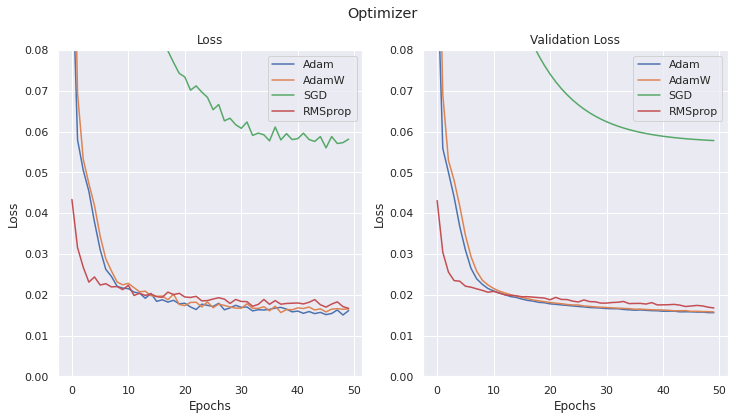

In [ ]:
plot_hparam_comparisons(opt_hparam_dict, "Optimizer", y_lim=(0,0.08))

In [ ]:
opt_hparam_dict = hparams_trial(opt_list, "opt",trials=20)
lr_hparam_dict = hparams_trial(lr_list, "lr",trials=20)
batch_hparam_dict = hparams_trial(mini_batch_list, "batch_size",trials=20)
reg_hparam_dict = hparams_trial(regularizer_list, "reg",trials=20)
regLambda_hparam_dict = hparams_trial(lambda_decay_list, "reg_decay",trials=20)

100%|██████████| 3/3 [07:29<00:00, 149.91s/it]


In [ ]:
d_list =  [opt_hparam_dict, lr_hparam_dict, batch_hparam_dict, reg_hparam_dict, regLambda_hparam_dict]
title_list = ["Optimizer", "Learning Rate", "Batch Size", "Regularizer", "Regularizer Lambda (L2)"]

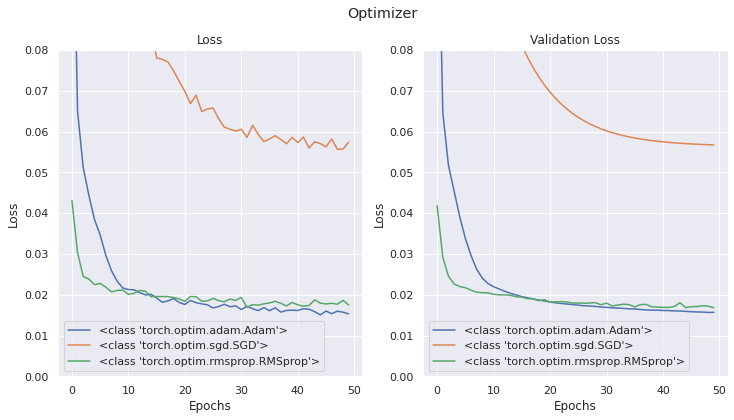

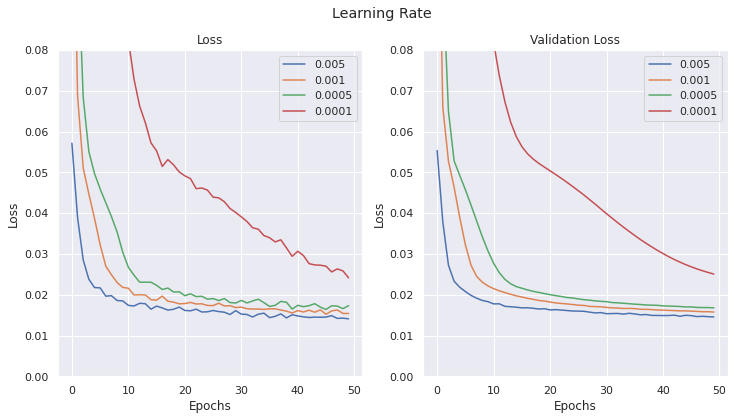

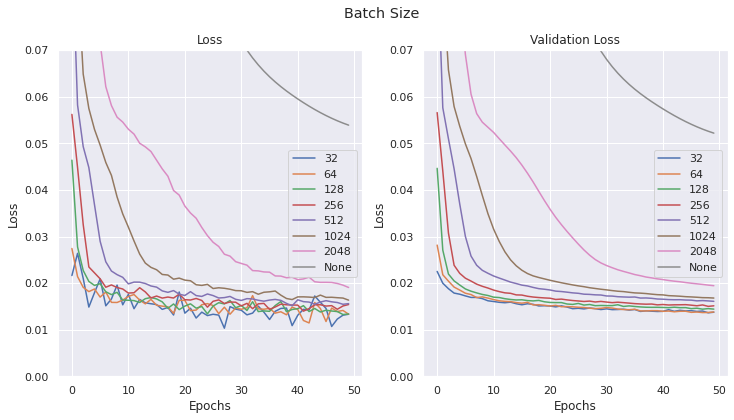

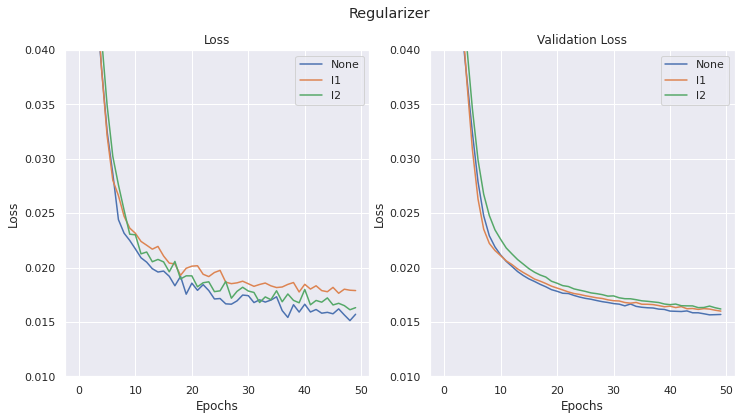

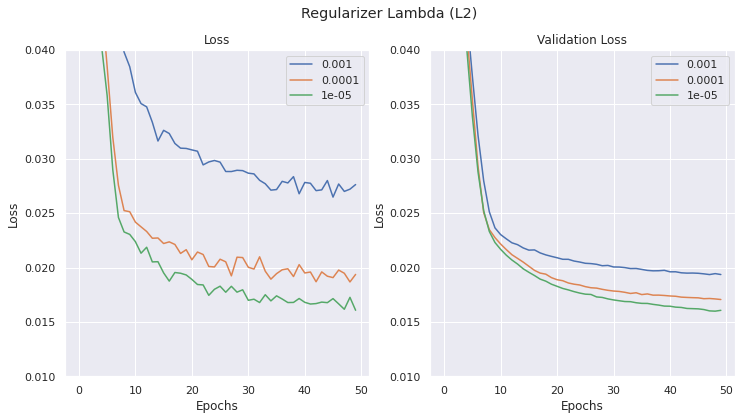

In [ ]:
for i, (d, title) in enumerate(zip(d_list,title_list)):
  if i == 0:
    lim = (0,0.08)
  if i == 1:
    lim = (0,0.08)
  if i == 2:
    lim = (0,0.07)
  if i == 3:
    lim = (0.01,0.04)
  if i == 4:
    lim = (0.01,0.04)
  plot_hparam_comparisons(d, title, y_lim=lim)

In [ ]:
# plot_hparam_comparisons(batch_hparam_dict, "Batch Size", y_lim=(0,0.25))

# Pre-Defined Functions

In [ ]:
def save_regressor(trained_model): 
    """ 
    Utility function to save the trained regressor model in part2_model.pickle.
    """
    # If you alter this, make sure it works in tandem with load_regressor
    with open('part2_model.pickle', 'wb') as target:
        pickle.dump(trained_model, target)
    print("\nSaved model in part2_model.pickle\n")


def load_regressor(): 
    """ 
    Utility function to load the trained regressor model in part2_model.pickle.
    """
    # If you alter this, make sure it works in tandem with save_regressor
    with open('part2_model.pickle', 'rb') as target:
        trained_model = pickle.load(target)
    print("\nLoaded model in part2_model.pickle\n")
    return trained_model



def RegressorHyperParameterSearch(opt_list=None,lr_list=None,mini_batch_list=None,regularizer=None,lambda_decay_list=None): 
  """
  Performs a hyper-parameter for fine-tuning the regressor implemented 
  in the Regressor class.

  Exhaustive Gridsearch style.

  Arguments:
      Lists of values for parameters to be explored.
      
  Returns:
      Optimised hyper-parameters. 

  """
  #######################################################################
  #                       ** START OF YOUR CODE **
  #######################################################################

  df = pd.read_csv('housing.csv', index_col=None)
  X = df.iloc[:,:-1]
  y = df.iloc[:,-1]

  # Parameters to explore
  opt_list = [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop] if opt_list is None else opt_list
  lr_list = [0.5e-2, 1e-3, 0.5e-3, 1e-4] if lr_list is None else lr_list
  mini_batch_list = [32,64,128,256,512,1024,2048,None] if mini_batch_list is None else mini_batch_list
  regularizer_list = [None, "l1", "l2"] if regularizer_list is None else regularizer_list
  lambda_decay_list = [1e-3, 1e-4, 1e-5] if lambda_decay_list is None else lambda_decay_list

  best = {"rmse":np.inf}
  
  row_indx = 0
  for opt in opt_list:
    # Get optimizer name as str.
    opt_name = str(opt).split(".")[-1][:-2]
    print(opt_name)
    for lr in lr_list:
      print("   lr:{}".format(lr))
      for mini_batch in mini_batch_list:
        print("       mini_batch:{}".format(mini_batch))
        for reg in regularizer_list:
          print("           regularizer:{}".format(reg))
          for lambda_decay in lambda_decay_list:
            print("             lambda_decay:{}".format(lambda_decay if reg is not None else 0))
            
            # Split data.
            X_train, X_test, y_train, y_test = train_test_split(X,y)
            # Validation
            X_train, X_val, y_train, y_val = train_test_split(X_train,y_train)

            callbacks = {
                "verbose" : False,
                "monitor" : "val_loss",
                "patience" : 8
            }

            # Instance, fit, and score regressor model.
            regressor = Regressor(X_train, nb_epoch=500).to(device)
            regressor.fit(X_train,y_train, lr=lr, opt_func=opt, regularizer=reg, lambda_decay=lambda_decay, batch_size=mini_batch, callbacks=callbacks, validation_set=[X_val,y_val])
            rmse = regressor.score(X_test, y_test)

            if rmse < best["rmse"]:
              best["rmse"] = rmse
              best["optimizer"] = opt
              best["lr"] = lr
              best["batch_size"] = mini_batch
              best["regularizer"] = reg
              best["regularizer_lambda"] = lambda_decay

            # If no regularizer than skip all but one lambda_decay training values.
            # This ensure only one trial under no reg, rather than len(lambda_decay_list) trials under no reg.
            if reg is None:
              break

  del best["rmse"]
  return best

  #######################################################################
  #                       ** END OF YOUR CODE **
  #######################################################################



def example_main():

    output_label = "median_house_value"

    # Use pandas to read CSV data as it contains various object types
    # Feel free to use another CSV reader tool
    # But remember that LabTS tests take Pandas Dataframe as inputs

    data = pd.read_csv('housing.csv', index_col=None)

    # Spliting input and output
    X = data.loc[:, data.columns != output_label]
    y = data.loc[:, [output_label]]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

    # Training
    # This example trains on the whole available dataset. 
    # You probably want to separate some held-out data 
    # to make sure the model isn't overfitting
    regressor = Regressor(X_train, nb_epoch = 500)
    regressor.fit(X_train, y_train, validation_set=[X_val,y_val])
    save_regressor(regressor)

    # Error
    error = regressor.score(X_train, y_train)
    print("\nRegressor error: {}\n".format(error))


if __name__ == "__main__":
    example_main()


Saved model in part2_model.pickle


Regressor error: 56278.28844872394



In [ ]:
from google.colab import files

files.download("part2_model.pickle")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
trained_model = load_regressor()


Loaded model in part2_model.pickle

